# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: ***  *** 203909320 , 311132468 *** 

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
#### Your code here ####
def plot_df_hist(df,bins,alpha,title):
    ax = df[df['y']==0].hist(column='x1',bins =bins, alpha = alpha,label = 'Labeled 0')
    df[df['y']==1].hist(column='x1',ax=ax,bins =bins, alpha = alpha,label = 'Labeled 1')
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.xlabel('1st FEATURE: x1',fontsize = 10)
    plt.show()
def plot_df_scatter(df,title):
    ax = df[df['y']==0].plot.scatter(x='x1',y= 'x2', c='blue',label = 'Labeled 0')
    df[df['y']==1].plot.scatter(x='x1',y= 'x2', c='red',ax=ax,label = 'Labeled 1')
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.xlabel('x1',fontsize = 10)
    plt.ylabel('x2',fontsize = 10)
    plt.show()

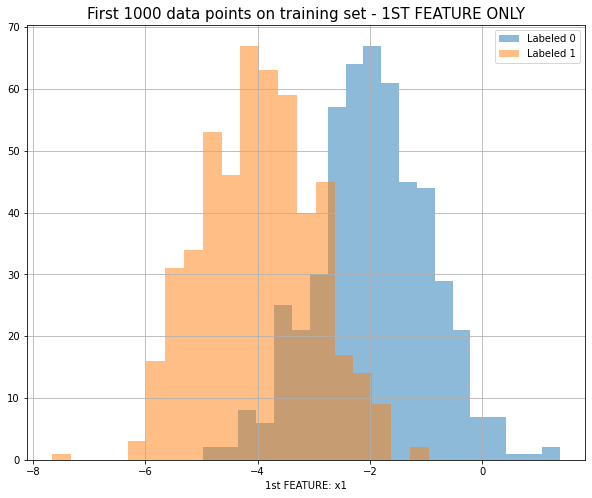

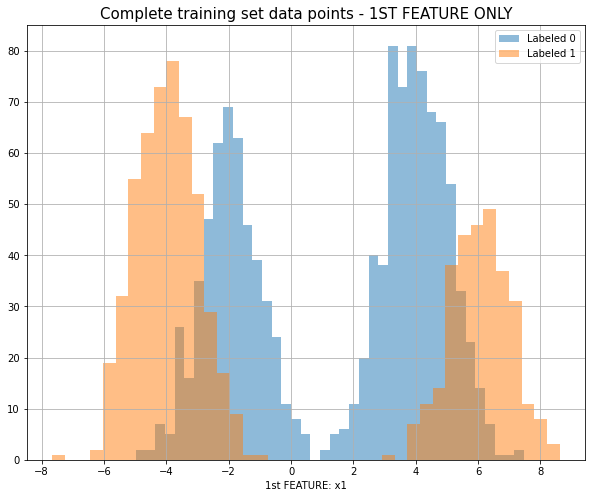

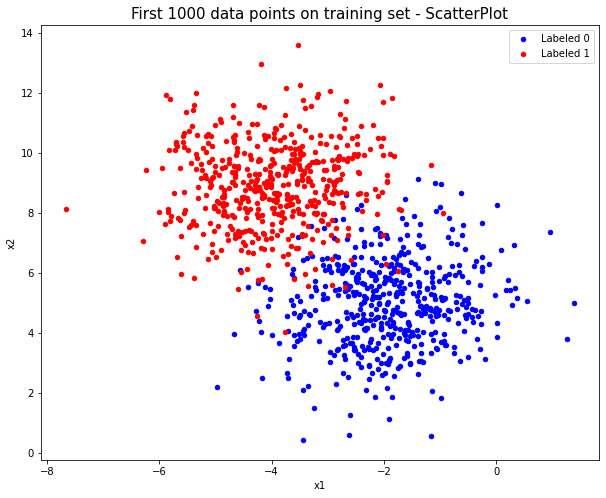

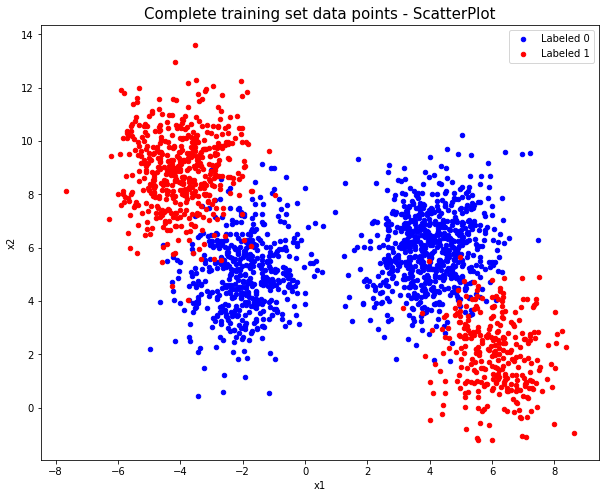

In [5]:
#First 1000 data points histogram:
plot_df_hist(training_set.head(1000),20,0.5,'First 1000 data points on training set - 1ST FEATURE ONLY')

#All data points histogram:
plot_df_hist(training_set,40,0.5,'Complete training set data points - 1ST FEATURE ONLY')

#First 1000 data points scatterplot:
plot_df_scatter(training_set.head(1000),'First 1000 data points on training set - ScatterPlot')

#All data points scatterplot:
plot_df_scatter(training_set,'Complete training set data points - ScatterPlot')

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None # Store the theta vector in an attribute of the LogisticRegressionGD object
        self.J_history = [] # Use a python list to save cost in every iteration
        self.labels = []

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        Sigmoid =lambda a : 1/(1+ np.exp(-a)) #sigmoid function_ locally defined
        cost_logist = lambda y,h_x : (1/y.shape[0])*(-y@np.log(h_x)-(1-y)@np.log(1-h_x)) #loss of binary cross entropy locally defined
        X = np.column_stack((np.ones(len(X)), X)) #Applying Bias trick
        np.random.seed(self.random_state)
        theta = np.random.random(X.shape[1]) # avoid changing the original thetas
        count_div = 0 #variable to spot divergence
        for i in range(self.n_iter):
            h_0 = Sigmoid(X@theta)
            theta = theta - (self.eta) * ((h_0 - y)@X) # i dropped the 1/m constant, as shown in the lectures and recitation slides
            self.J_history.append(cost_logist(y, h_0))
            if i > 0:
                if np.abs(self.J_history[i-1] - self.J_history[i]) < self.eps:
                    break
            if self.J_history[i] > 1000:
                count_div+=1
            if count_div > 20:
                self.J_history[i] = np.inf
                print("Divergence occured for eta = ",self.eta)
                break
        self.theta = theta
    
    def predict(self, X):
        """Return the predicted class label"""
        X = np.column_stack((np.ones(len(X)), X)) #Applying Bias trick
        h_theta = 1/(1+ np.exp(-(X@self.theta))) #Applying SIgmoid
        h_theta = np.round(h_theta) # if an instance lower(or equal) to 0.5 its rounded to 0, else labeled 1
        self.labels = h_theta
        return h_theta
    
    def accuracy(self,y): #my addition in order to check accuracy
        correct = (self.labels == y).sum()
        return (correct/ y.size)


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
def k_fold_cross_validation(k,Xs,ys,eta,eps,n_iter,random_state):
    accuracy_list = []
    for x_val,y_val in zip(np.split(Xs,k),np.split(ys,k)): #each fold will use as validation set, and the rest will use as training set
        idx = np.where(np.abs((Xs[:,np.newaxis,:] - x_val)).sum(axis=2)==0)
        train_set_X,train_set_y = np.delete(Xs, idx[0],axis= 0), np.delete(ys, idx[0],axis= 0)
        
        #Fit the model with training set
        logistic = LogisticRegressionGD(eta,n_iter,eps,random_state)
        logistic.fit(train_set_X,train_set_y)
        #Validate the model with validation set
        
        _ = logistic.predict(x_val)
        accuracy_list.append(logistic.accuracy(y_val))
        
    return np.array(accuracy_list).mean() #return mean accuracy of the k-fold cross validation

In [8]:
%%time
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
eta_eps_dict = {}

#shuffling the data first
training_to_shaffle= training_set.copy()
training_to_shaffle= training_to_shaffle.sample(frac=1)
training_to_shaffle
#split the dataframe to X features and y labels
X_training_tofold, y_training_tofold = training_to_shaffle[['x1', 'x2']].values, training_to_shaffle['y'].values
#apply k(=5)-fold cross validation to find best eta and eps
for eta in etas:
    for eps in epss:
        acc =  k_fold_cross_validation(5,X_training_tofold,y_training_tofold,eta,eps,10000,1)
        eta_eps_dict[("eta="+str(eta),"eps="+str(eps))] = np.round(acc,3)
eta_eps_dict

Wall time: 1min 39s


{('eta=0.05', 'eps=0.01'): 0.598,
 ('eta=0.05', 'eps=0.001'): 0.598,
 ('eta=0.05', 'eps=0.0001'): 0.598,
 ('eta=0.05', 'eps=1e-05'): 0.598,
 ('eta=0.05', 'eps=1e-06'): 0.598,
 ('eta=0.005', 'eps=0.01'): 0.598,
 ('eta=0.005', 'eps=0.001'): 0.598,
 ('eta=0.005', 'eps=0.0001'): 0.598,
 ('eta=0.005', 'eps=1e-05'): 0.598,
 ('eta=0.005', 'eps=1e-06'): 0.598,
 ('eta=0.0005', 'eps=0.01'): 0.598,
 ('eta=0.0005', 'eps=0.001'): 0.598,
 ('eta=0.0005', 'eps=0.0001'): 0.598,
 ('eta=0.0005', 'eps=1e-05'): 0.598,
 ('eta=0.0005', 'eps=1e-06'): 0.598,
 ('eta=5e-05', 'eps=0.01'): 0.522,
 ('eta=5e-05', 'eps=0.001'): 0.565,
 ('eta=5e-05', 'eps=0.0001'): 0.573,
 ('eta=5e-05', 'eps=1e-05'): 0.689,
 ('eta=5e-05', 'eps=1e-06'): 0.798,
 ('eta=5e-06', 'eps=0.01'): 0.4,
 ('eta=5e-06', 'eps=0.001'): 0.488,
 ('eta=5e-06', 'eps=0.0001'): 0.549,
 ('eta=5e-06', 'eps=1e-05'): 0.57,
 ('eta=5e-06', 'eps=1e-06'): 0.689}

In [9]:
best_eta, best_eps = float(max(eta_eps_dict, key=eta_eps_dict.get)[0].split('=')[1]) , float(max(eta_eps_dict, key=eta_eps_dict.get)[1].split('=')[1])
print("The best eta & eps are: {0}".format(max(eta_eps_dict, key=eta_eps_dict.get)))

The best eta & eps are: ('eta=5e-05', 'eps=1e-06')


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [10]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    p = (1/np.sqrt(2*np.pi*(sigma**2))*np.exp(-((data-mu)**2)/(2*(sigma**2))))
    return p

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [11]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self,em = None, k=1, n_iter=1000, eps=0.01, random_state=42,w=[],mu=[],sigma=[],log_like = {}):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.w = w
        self.mu = mu
        self.sigma = sigma
        self.em = em #dataframe which will represent the data
        self.log_like = log_like

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        self.w = np.ones(self.k)/self.k
        self.mu = np.random.random(self.k)
        self.sigma = np.random.random(self.k)
        #intialize a dataframe of the input data
        em = {'X': data.copy()}
        for i in range(self.k):
            em[str(i+1)] = data.copy()
        em['log_lik'] = data.copy()
        em['liklyhood'] = data.copy()
        self.em = pd.DataFrame(em)
        
    @staticmethod
    def respo(x,k,w,miu,sigma): # K as for index for specific Gaussian
        numerator = w[k-1]*norm_pdf(x,miu[k-1],sigma[k-1])
        denominator = 0
        for j in range(miu.size):
            denominator+= w[j]*norm_pdf(x,miu[j],sigma[j])
        if denominator ==0:
            return None
        return numerator / denominator

    @staticmethod
    def calc_log_like(x,w,miu,sigma): #calculating the log likelihood for a pandas series
        val = 0
        for j in range(w.size):
            val+= w[j] * norm_pdf(x,miu[j],sigma[j])
        return -np.log(val)
    
    @staticmethod
    def calc_liklyhood(x,w,miu,sigma): #calculating the likelihood for a pandas series
        val = 0
        for j in range(w.size):
            val+= w[j] * norm_pdf(x,miu[j],sigma[j])
        return val   

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        #dataframe initialization
        for i in range(self.k):
            self.em.iloc[:,i+1] = self.em.X.apply(EM.respo,k=i+1,w=self.w,miu=self.mu,sigma=self.sigma)      

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for i in range(self.k):
            self.w[i] = self.em.iloc[:,i+1].sum() / self.em.X.size
            self.mu[i] = (self.em.X * self.em.iloc[:,i+1]).sum()/(self.em.X.size*self.w[i])
            self.sigma[i] = np.sqrt((self.em.iloc[:,i+1] * ((self.em.X - self.mu[i])**2)).sum()/(self.em.X.size*self.w[i]))
        self.em.log_lik = self.em.X.apply(EM.calc_log_like,w=self.w,miu=self.mu,sigma=self.sigma)


    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        prev_loglik = 0
        self.init_params(data)
        self.log_like.update({0: self.em.log_lik.sum()})
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            if np.isinf(self.em.log_lik.sum()) or (np.abs(self.em.log_lik.sum() - prev_loglik) <= self.eps):
                break
            prev_loglik = self.em.log_lik.sum()
            self.log_like.update({i+1: prev_loglik})
            
    def get_dist_params(self):
        return self.w,self.mu,self.sigma
    
    def get_final_liklyhood(self,data):
        val = 0
        for j in range(self.w.size):
            val+= self.w[j] * norm_pdf(data,self.mu[j],self.sigma[j])
        return val

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [12]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=42):
        self.k = k
        self.random_state = random_state
        #parameters to initialize the EM algorithm:
        self.em_f1_0 = None
        self.em_f1_1 = None
        self.em_f2_0 = None
        self.em_f2_1 = None
        self.pred_vector = None
        self.p_a_0 = None
        self.p_a_1 = None
        
    def get_prior(self,y): 
        """
        Returns the prior porbability of the class according to the dataset distribution.
        class has to include 2 labels only - 0 and 1
        """
        p_a_0 = ((y == 0).sum() / y.size)
        p_a_1 = 1 - p_a_0
        return p_a_0 , p_a_1
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        #First, get prior probabilities:
        self.p_a_0 ,  self.p_a_1 = self.get_prior(y)
        #initialize EM on each feature corresponding to his class labelL
        #1)
        self.em_f1_0 = EM(k =  self.k)
        data_em_f1_0 = X[np.where(y == 0)[0],0]
        self.em_f1_0.fit(data_em_f1_0)
        #2)    
        self.em_f1_1 = EM(k =  self.k)
        data_em_f1_1 = X[np.where(y == 1)[0],0]
        self.em_f1_1.fit(data_em_f1_1)
        #3)
        self.em_f2_0 = EM(k =  self.k)
        data_em_f2_0 = X[np.where(y == 0)[0],1]
        self.em_f2_0.fit(data_em_f2_0)
        #4)    
        self.em_f2_1 = EM(k =  self.k)
        data_em_f2_1 = X[np.where(y == 1)[0],1]
        self.em_f2_1.fit(data_em_f2_1)
        
    
    def predict(self, X):
        """Return the predicted class label""" 
#             - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        #First, get prior probabilities:
        #Now get liklyhood
        likly_f1_0 = self.em_f1_0.get_final_liklyhood(X[:,0])
        likly_f1_1 = self.em_f1_1.get_final_liklyhood(X[:,0])
        likly_f2_0 = self.em_f2_0.get_final_liklyhood(X[:,1])
        likly_f2_1 = self.em_f2_1.get_final_liklyhood(X[:,1])
        # Calculate posterior probability
        posterior_0 = self.p_a_0 * likly_f1_0 * likly_f2_0 
        posterior_1 = self.p_a_1 * likly_f1_1 * likly_f2_1
        #build the prediction vector
        pred_vector = np.zeros(posterior_0.shape)
        pred_vector[posterior_0 < posterior_1] = 1 # 1 if the posterior probability of class 1 is higher and 1 otherwise
        self.pred_vector = pred_vector
        return pred_vector
    
    def accuracy(self,y): #my addition in order to check accuracy
        correct = (self.pred_vector == y).sum()
        return (correct/ y.size)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

Logistic regression Accuracy:
     Training Accuracy - 1000 points: 0.965
     Test Accuracy - 500 points: 0.938

Naive Bayes:
     Training Accuracy - 1000 points: 0.966
     Test Accuracy - 500 points: 0.942


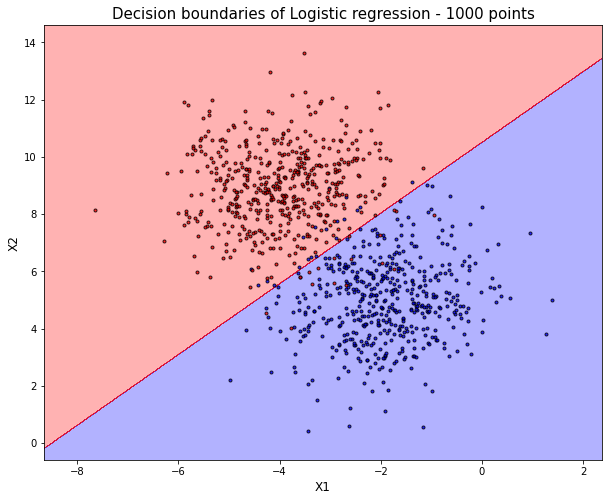

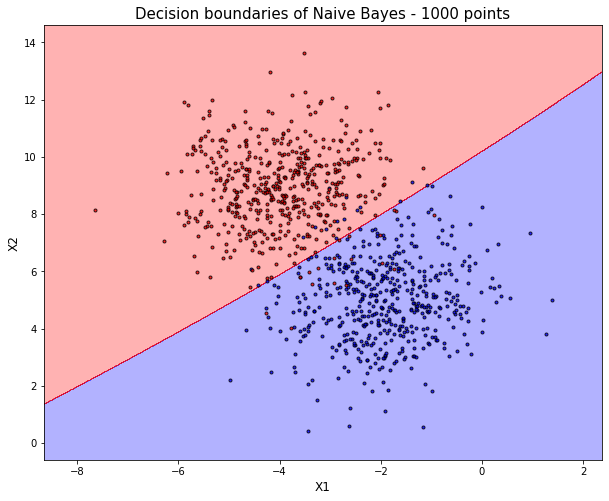

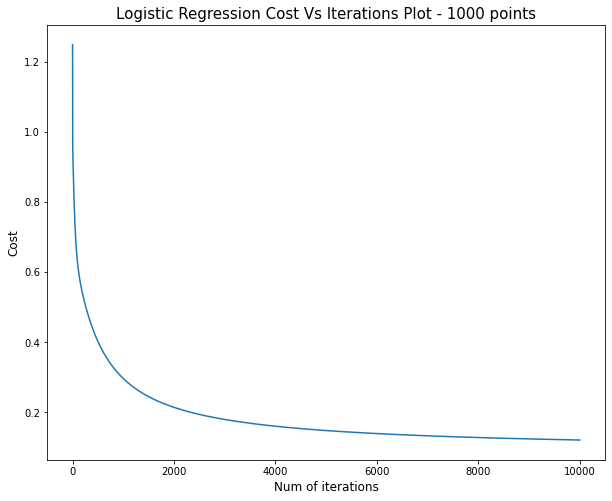

In [13]:
## Fit logistic regression - First 1000 training points and first 500 test point
logistic = LogisticRegressionGD(eta=best_eta, n_iter=10000, eps=best_eps, random_state=42)
logistic.fit(X_training[:1000,:],y_training[:1000])

#logistic regression training accuracy 
_= logistic.predict(X_training[:1000,:])
logistic_train_acc=logistic.accuracy(y_training[:1000])

#logistic regression test accuracy 
_= logistic.predict(X_test[:500,:])
logistic_test_acc=logistic.accuracy(y_test[:500])

## Fit Naive Bayes - First 1000 training points and first 500 test point
naive_b  = NaiveBayesGaussian(k=1) #As seen in first part of notebook - for 1000 points - 1 gaussian dist for a feature
naive_b.fit(X_training[:1000,:],y_training[:1000])

#Naive Bayes training accuracy
_= naive_b.predict(X_training[:1000,:])
naive_b_train_accuracy=naive_b.accuracy(y_training[:1000])

#Naive Bayes test accuracy
_= naive_b.predict(X_test[:500,:])
naive_b_test_accuracy=naive_b.accuracy(y_test[:500])

print("Logistic regression Accuracy:\n     Training Accuracy - 1000 points: {0}\n     Test Accuracy - 500 points: {1}\n".format(logistic_train_acc,logistic_test_acc))
print("Naive Bayes:\n     Training Accuracy - 1000 points: {0}\n     Test Accuracy - 500 points: {1}".format(naive_b_train_accuracy,naive_b_test_accuracy))

#ploting the decision boundaries For each model:

plot_decision_regions(X_training[:1000,:],y_training[:1000], logistic, resolution=0.01)
plt.title("Decision boundaries of Logistic regression - 1000 points",fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()
plot_decision_regions(X_training[:1000,:],y_training[:1000], naive_b, resolution=0.01)
plt.title("Decision boundaries of Naive Bayes - 1000 points",fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()
#Cost Vs iterations for Logistic regression:

plt.plot(logistic.J_history)
plt.title("Logistic Regression Cost Vs Iterations Plot - 1000 points",fontsize= 15)
plt.xlabel("Num of iterations",fontsize= 12)
plt.ylabel("Cost",fontsize= 12)
plt.show()


# plotting explanations:
For 1000 points data , as seen on 'visualing the data' part,there are two classes of centroids and both are quite well seperated.Hence applying logistic regression or naive bayes will both yield really good results because most of the data generated that so it is pretty good linearly seperatble

1. we can see that the logistic regression handled the seperation really good with high accuracy.
2. for the naive bayes seperation, as predicted it also yields great results with high accuracy (almost the same as logistic regression)
3. As can be seen, the logistic regression cost/iteration plot is in a logarithmic shape, which is expected because the binary cross entropy was based on logarithmic functions. furthermore, we can witness very quick convergence



Logistic regression Accuracy:
     Training Accuracy - All points: 0.809
     Test Accuracy - All points: 0.804

Naive Bayes:
     Training Accuracy - All points: 0.9215
     Test Accuracy - All points: 0.902


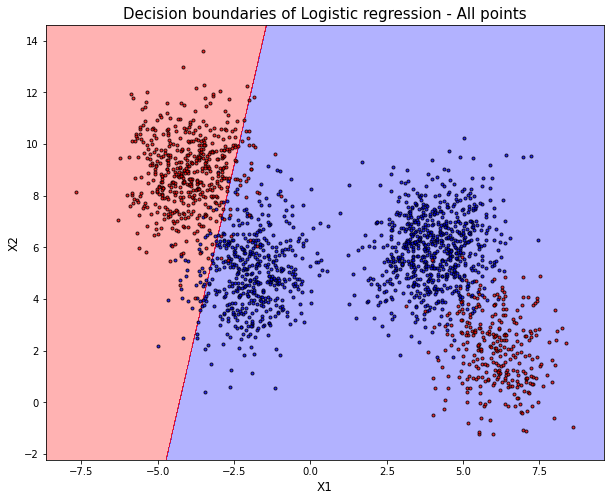

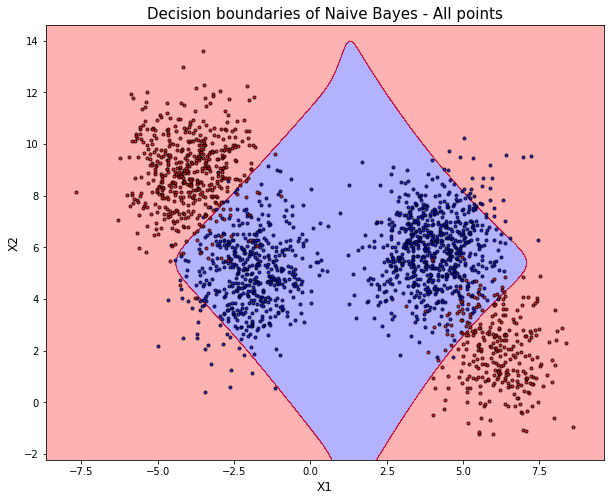

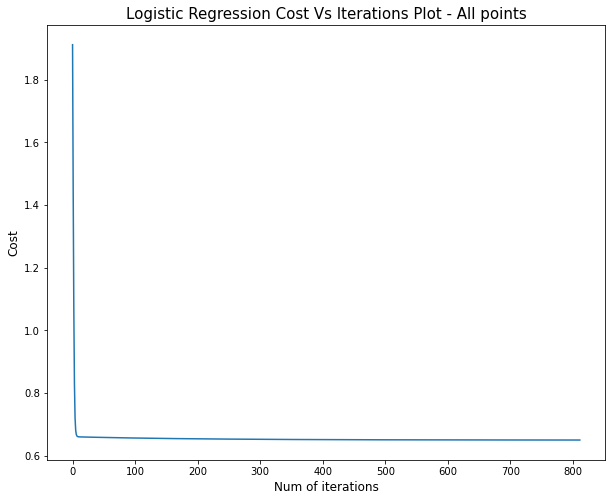

In [14]:
## Fit logistic regression - Full training points and first 500 test point
logistic = LogisticRegressionGD(eta=best_eta, n_iter=10000, eps=best_eps, random_state=1)
logistic.fit(X_training,y_training)

#logistic regression training accuracy 
_= logistic.predict(X_training)
logistic_train_acc=logistic.accuracy(y_training)

#logistic regression test accuracy 
_= logistic.predict(X_test)
logistic_test_acc=logistic.accuracy(y_test)

## Fit Naive Bayes - Full training points and Full test point
naive_b  = NaiveBayesGaussian(k=2) #As seen in first part of notebook - for 1000 points - 1 gaussian dist for a feature
naive_b.fit(X_training,y_training)

#Naive Bayes training accuracy
_= naive_b.predict(X_training)
naive_b_train_accuracy=naive_b.accuracy(y_training)

#Naive Bayes test accuracy
_= naive_b.predict(X_test)
naive_b_test_accuracy=naive_b.accuracy(y_test)

print("Logistic regression Accuracy:\n     Training Accuracy - All points: {0}\n     Test Accuracy - All points: {1}\n".format(logistic_train_acc,logistic_test_acc))
print("Naive Bayes:\n     Training Accuracy - All points: {0}\n     Test Accuracy - All points: {1}".format(naive_b_train_accuracy,naive_b_test_accuracy))

#ploting the decision boundaries For each model:

plot_decision_regions(X_training,y_training, logistic, resolution=0.01)
plt.title("Decision boundaries of Logistic regression - All points",fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()

plot_decision_regions(X_training,y_training, naive_b, resolution=0.01)
plt.title("Decision boundaries of Naive Bayes - All points",fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()
#Cost Vs iterations for Logistic regression:

plt.plot(logistic.J_history)
plt.title("Logistic Regression Cost Vs Iterations Plot - All points",fontsize= 15)
plt.xlabel("Num of iterations",fontsize= 12)
plt.ylabel("Cost",fontsize= 12)
plt.show()

# plotting explanations:
Now, as the full data presented to us, as seen in the visualization part in the beggining, we know that the data is not seperable by a linear line, but it might be seperable by plane. we expect the linear regression to fail and the naive bayes to succeed due to the EM adjustment due to the fact that we saw in the histograms that the data distributed normally.

1. The first graph shows the disadvantages of logistic regression as a linear seperator - where the data is not linearly separable But how come the accuracy is so high - 80% if the data is not separable? The answer is that we note that the classifier was right on 3 out of 4 clusters of labels because of how the data is arranged, but it is due to chance completely.


2. On the second graph we see how good the naive bayes with EM deals with a graph that wasnt been able to seperabe by logistic regression. rather than seperating it with a line, now its seperated by plane and great accuracy achieved


3. We can witness very quick convergence with the cost graph but the shape looks less logarithmic. the reason is that the alogrithm converged that fast so it didnt get a perfect curvy shape , but just a little edgie curve



## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

###  Generating dataset that  Logistic Regression will work better than Naive Bayes.
In the following example i will show when logistic regression works better.

the Naive bayes with EM using gaussians hence assuming that points that are close to the centroind of each class are likely to be classified to this particular centroid.

on the other hand, the logistic regression only goal to classify each point correctly. i will generate a data with synthetic outliers that are from label 1 but close to the label 0 centroid, and show how naive bayes will be mistaken on those outliers and on the other hand the logistic regression will perform perfect linear seperation:  

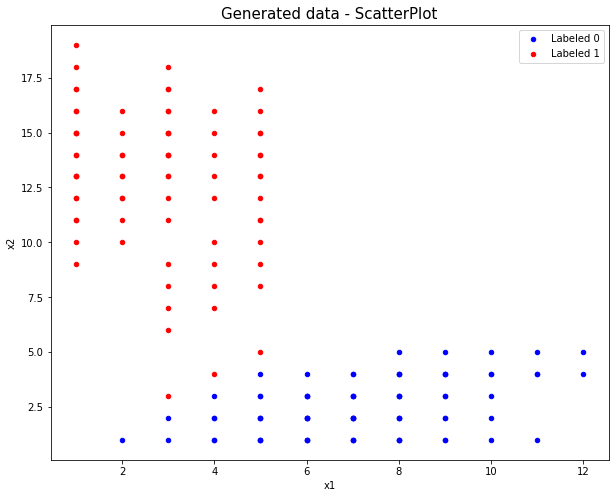

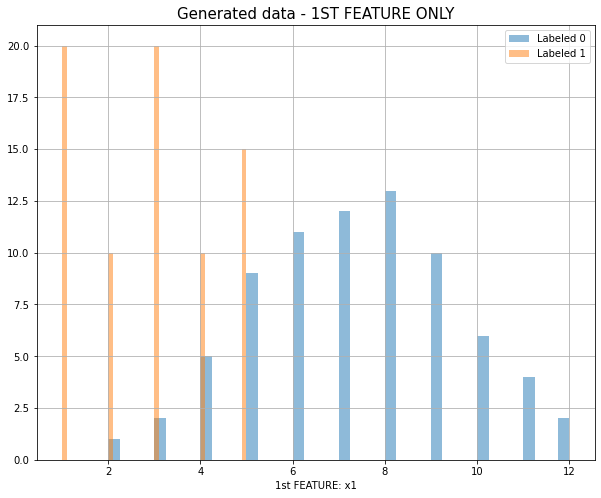

In [15]:
# Initializing a dataset
pos = np.array([[1,7], [1,9], [1,11], [2,10], [3,9], [1,13], [3,3],[5,5], [4,10], [5,11], [2,8], [3,11], [4,4],[3,12],[5,9]])
neg = np.array([[4,1], [5,1], [3,2], [2,1], [8,4], [6,2], [5,3],[4,2], [7,1], [5,4], [6,3], [7,4], [4,3], [5,2], [8,5]])
data_pos=pos
data_neg = neg
for i in range(1,5):
    data_pos = np.vstack((data_pos,pos + [0,i]))
    data_neg = np.vstack((data_neg,neg + [i,0]))
positives = np.vstack((data_pos[:,0],data_pos[:,1],np.ones(data_pos.shape[0]))).T
negatives = np.vstack((data_neg[:,0],data_neg[:,1],np.zeros(data_neg.shape[0]))).T
Total_data = pd.DataFrame(np.vstack((positives,negatives)),columns=['x1','x2','y'])
for index, row in Total_data.iterrows():
    if ((row['x1'],row['x2']) != (3,3)) and ((row['x1'],row['x2']) != (4,4)) and ((row['x1'],row['x2']) != (5,5)) and row['y'] == 1:
        row['x2']+=2
#Generated data scatter plot:
plot_df_scatter(Total_data,'Generated data - ScatterPlot')
#Generated data points histogram:
plot_df_hist(Total_data,40,0.5,'Generated data - 1ST FEATURE ONLY')

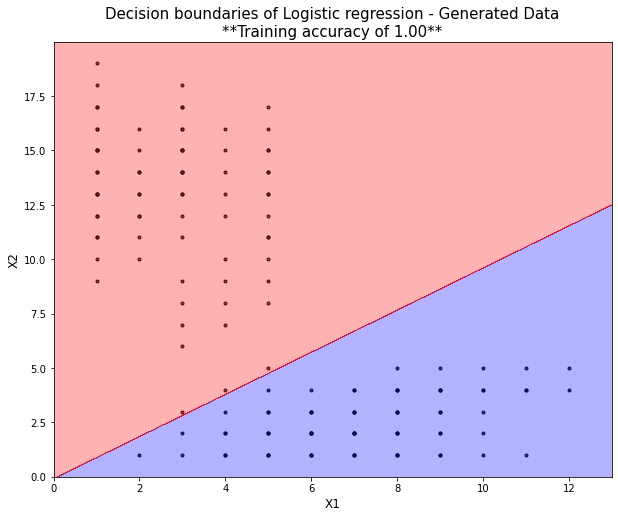

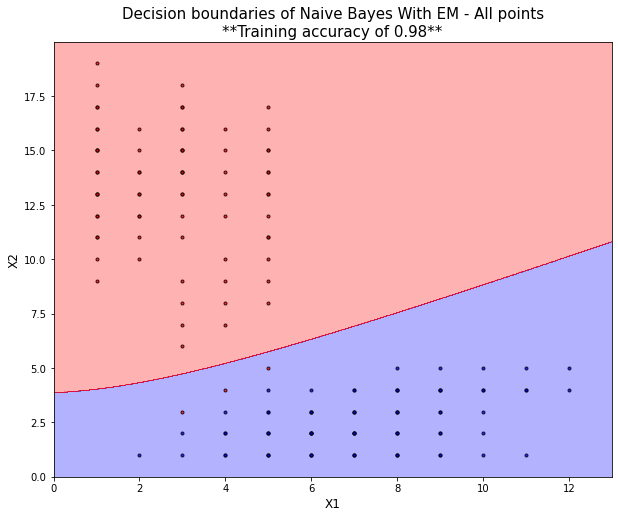

In [16]:
X_trainer, y_trainer = Total_data[['x1', 'x2']].values, Total_data['y'].values
## Fit logistic regression - Full training points and first 500 test point
logis = LogisticRegressionGD(eta=best_eta, n_iter=10000, eps=best_eps, random_state=1)
logis.fit(X_trainer,y_trainer)

#logistic regression training accuracy 
_= logis.predict(X_trainer)
logis_acc=logis.accuracy(y_trainer)

## Fit Naive Bayes - Full training points and Full test point
naive_lesser  = NaiveBayesGaussian(k=1) #As seen in first part of notebook - for 1000 points - 1 gaussian dist for a feature
naive_lesser.fit(X_trainer,y_trainer)

#Naive Bayes training accuracy
_= naive_lesser.predict(X_trainer)
naive_lesser_accuracy=naive_lesser.accuracy(y_trainer)
plot_decision_regions(X_trainer,y_trainer, logis, resolution=0.01)
plt.title("Decision boundaries of Logistic regression - Generated Data\n**Training accuracy of {0:.2f}**".format(logis_acc),fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()
plot_decision_regions(X_trainer,y_trainer, naive_lesser, resolution=0.01)
plt.title("Decision boundaries of Naive Bayes With EM - All points\n**Training accuracy of {0:.2f}**".format(naive_lesser_accuracy),fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
# plt.xlabel("Training accuracy of {0}".format(naive_lesser_accuracy),fontsize = 14)
plt.show()

**Note the points (3,3) , (4,4) , (5,5).
whereas the naive bayes fails to correctly classify due to short distance to other centroid of class, the logistic regression classify perfectly!** 

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

###  Generating dataset that Naive Bayes will work better than Logisitc Regression.
In the following example i will show when Naive bayes with EM works better.

my intuition was looking at XOR probelm, which we know that is not linearly separable hence the logistic regression wont perform well on it.

But what if we could tweak it a little, and use the naive bayes EM properties, and draw nearer some centroids, so the naive bayes EM will classify them together?

watch the next data generation:

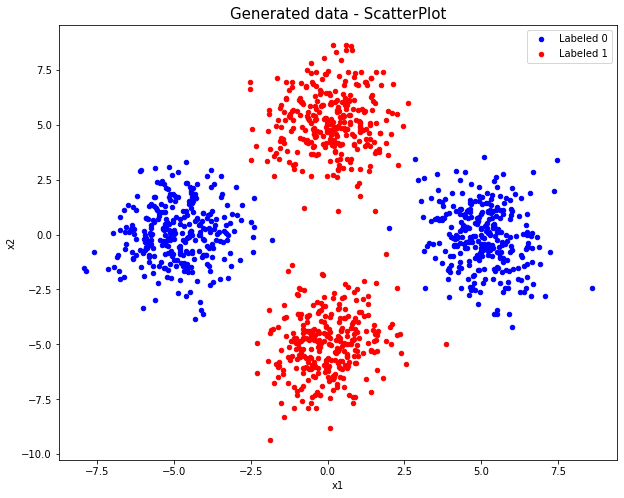

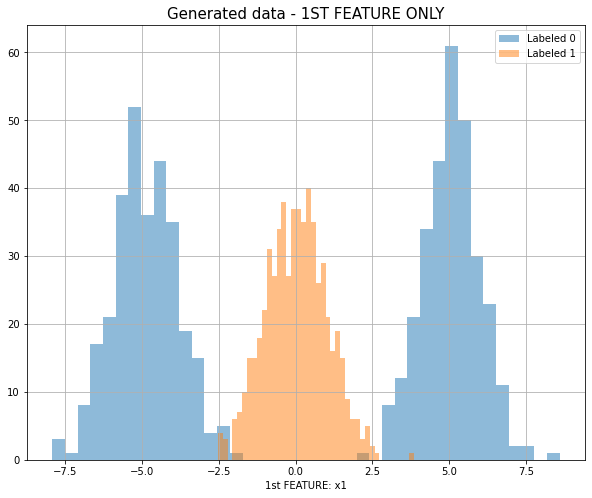

In [17]:
mean = [[0,-5], [-5, 0], [0, 5], [5, 0]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1,x2,y = [],[],[]
#positives generation:
a_pos,b_pos =  np.random.multivariate_normal(mean[0],cov[0],300).T
a_pos2,b_pos2 =  np.random.multivariate_normal(mean[2],cov[2],300).T
posit = np.vstack((np.hstack((a_pos,a_pos2)),np.hstack((b_pos,b_pos2)),np.ones(a_pos.shape[0]*2))).T
#Negatives generation:
a_neg,b_neg =  np.random.multivariate_normal(mean[1],cov[1],300).T
a_neg2,b_neg2 =  np.random.multivariate_normal(mean[3],cov[3],300).T
negat = np.vstack((np.hstack((a_neg,a_neg2)),np.hstack((b_neg,b_neg2)),np.zeros(a_neg.shape[0]*2))).T
data_best_bayes_em = np.vstack((posit,negat))
data_best_bayes_em = pd.DataFrame(data_best_bayes_em,columns=['x1','x2','y'])
#Generated data scatter plot:
plot_df_scatter(data_best_bayes_em,'Generated data - ScatterPlot')
#Generated data points histogram:
plot_df_hist(data_best_bayes_em,40,0.5,'Generated data - 1ST FEATURE ONLY')

We took the XOR problem, rotated the centroids, and generated the data in such way that the naive bayes EM algorithm will converge in a optimal way and could split the classes correctly , while the logistic regression will fail anyway:

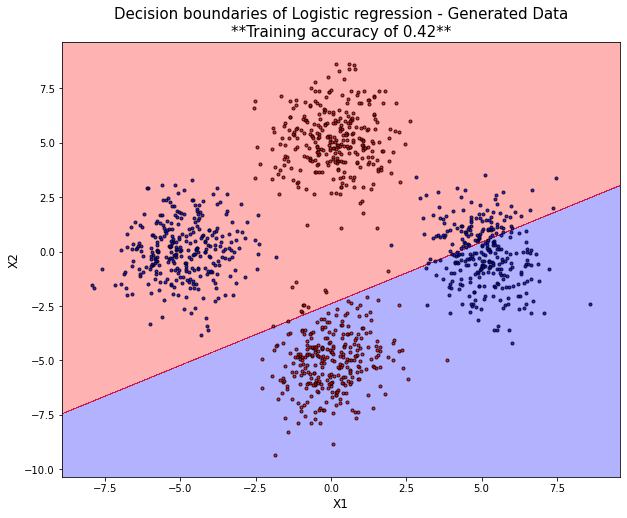

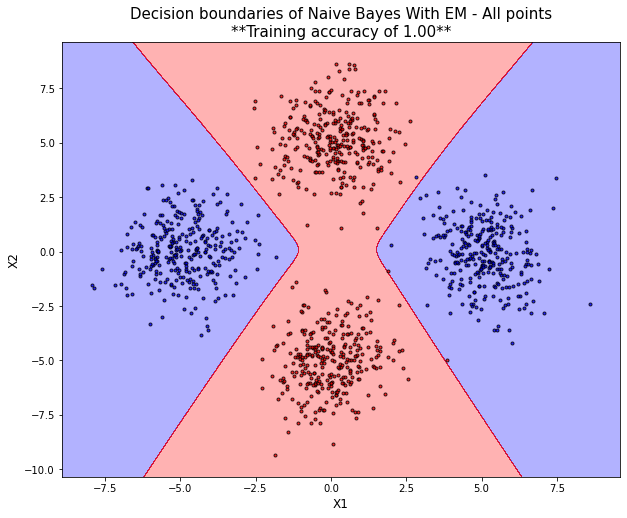

In [18]:
X_trainer, y_trainer = data_best_bayes_em[['x1', 'x2']].values, data_best_bayes_em['y'].values
## Fit logistic regression - Full training points and first 500 test point
logis = LogisticRegressionGD(random_state=1)
logis.fit(X_trainer,y_trainer)

#logistic regression training accuracy 
_= logis.predict(X_trainer)
logis_acc=logis.accuracy(y_trainer)

## Fit Naive Bayes - Full training points and Full test point
naive_lesser  = NaiveBayesGaussian(k=2) 
naive_lesser.fit(X_trainer,y_trainer)

#Naive Bayes training accuracy
_= naive_lesser.predict(X_trainer)
naive_lesser_accuracy=naive_lesser.accuracy(y_trainer)
plot_decision_regions(X_trainer,y_trainer, logis, resolution=0.01)
plt.title("Decision boundaries of Logistic regression - Generated Data\n**Training accuracy of {0:.2f}**".format(logis_acc),fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)
plt.show()
plot_decision_regions(X_trainer,y_trainer, naive_lesser, resolution=0.01)
plt.title("Decision boundaries of Naive Bayes With EM - All points\n**Training accuracy of {0:.2f}**".format(naive_lesser_accuracy),fontsize= 15)
plt.xlabel("X1",fontsize= 12)
plt.ylabel("X2",fontsize= 12)

plt.show()

## **So as seen above, the naive bayes did wonderful job splitting the data with incredible accuracy where the logistic regression couldnt handle the problem in the first place, thus failing** 